In [1]:
from pathlib import Path
import pickle
import sys

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

sys.path.insert(0, str(Path.cwd() / "Source"))
from BOGP import utils
from BOGP.optimization import plotting
from BOGP.optimization.optimizer import Optimizer, BayesianOptimizationGPConfig, BOGPResults, RandomResults

ROOT = Path.home() / "Research" / "Projects" / "BOGP"
DATAPATH = ROOT / "Data" / "Simulations"
FIGUREPATH = ROOT / "Reports" / "Figures"


## Simulations

We next demonstrate the performance characteristics of the Bayesian optimization method using simulations under a variety of configurations. Simulations are modeled after the SWELLEX96 underwater acoustics experiment conducted off the coast of Southern California. In the SWELLEX96 experiment, a vertical line array (VLA) of 64~hydrophones evenly spaced between depths of 94.125 and 212.5~m recorded multi-tonal transmissions from a towed acoustic source at a depth of 61~m.  The closest point of approach (CPA) of the source was . For this study, a single-frequency transmission is simulated at 201 Hz from a depth of 61~m.  In the following sections, range estimation, source localization, and geoacoustic inversion are demonstrated fo

### Range Estimation

In this scenario, we estimate the range to an acoustic source from an array.

In [2]:
evaluations = {
    "acq_func": ["ProbabilityOfImprovement", "ExpectedImprovement", "qExpectedImprovement", "random"],
    "acq_func_abbrev": ["PI", "EI", "qEI", "Rand"],
    "snr": ["inf", "10"],
    "rec_r": ["0.5", "3.0", "6.0", "10.0"]
}
# folders = utils.folders_of_evaluations(evaluations)
EXPERIMENT1 = DATAPATH / "bogp" / "range_estimation"
df1 = pd.read_csv(EXPERIMENT1 / "aggregated.csv", index_col=0)
df1["best_param"] = df1["best_param"].str.strip("[").str.strip("]").astype(float)
df1 = df1[df1["snr"] == 10]

EXPERIMENT2 = DATAPATH / "random" / "range_estimation"
df2 = pd.read_csv(EXPERIMENT2 / "aggregated.csv", index_col=0)
df2["best_param"] = df2["best_param"].str.strip("[").str.strip("]").astype(float)
df2 = df2[df2["snr"] == 10]

dfr = pd.concat([df1, df2])
del df1, df2

In [3]:
evaluations = {
    "acq_func": ["ProbabilityOfImprovement", "ExpectedImprovement", "qExpectedImprovement", "random"],
    "acq_func_abbrev": ["PI", "EI", "qEI", "Rand"],
    "snr": ["inf", "10"],
    "rec_r": ["0.5", "3.0", "6.0", "10.0"],
    "src_z": ["62"]
}

EXPERIMENT1 = DATAPATH / "bogp" / "localization"
df1 = pd.read_csv(EXPERIMENT1 / "aggregated.csv", index_col=0)
new_cols = df1["best_param"].str.strip("[ ").str.strip(" ]").str.split(" ", n=1, expand=True)
new_cols.columns = [f"best_param{col}" for col in new_cols.columns]
df1 = pd.concat([df1, new_cols], axis=1).drop("best_param", axis=1)
df1 = df1[df1["snr"] == 10]

EXPERIMENT2 = DATAPATH / "random" / "localization"
df2 = pd.read_csv(EXPERIMENT2 / "aggregated.csv", index_col=0)
new_cols = df2["best_param"].str.strip("[ ").str.strip(" ]").str.split(" ", n=1, expand=True)
new_cols.columns = [f"best_param{col}" for col in new_cols.columns]
df2 = pd.concat([df2, new_cols], axis=1).drop("best_param", axis=1)
df2 = df2[df2["snr"] == 10]

dfl = pd.concat([df1, df2])
del df1, df2

Performance history is shown for the range estimation optimization using each acquisition function for a combination of ranges and signal-to-noise ratios, with the best observed value plotted for each sequential evaluation of the objective function.  Solid lines indicate mean performance history for the 1000 Monte Carlo simulations, and the shaded regions indicate standard deviation.

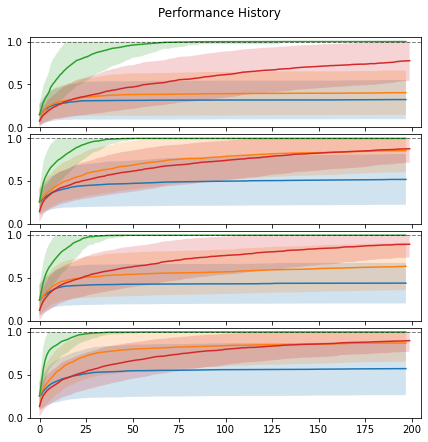

In [16]:
fig = plotting.plot_aggregated_data(
    dfr,
    evaluations,
    "best_value",
    optimum=1.0,
    upper_threshold=1.0,
    title="Performance History",
    xlabel="Evaluation",
    ylabel="$\hat{f}(\mathbf{x})$",
    xlim=[-5, 205],
    ylim=[0, 1.05]
)
# fig.savefig(FIGUREPATH / "Localization_PerfHist.png", dpi=200, facecolor="white", bbox_inches="tight")
plt.show()

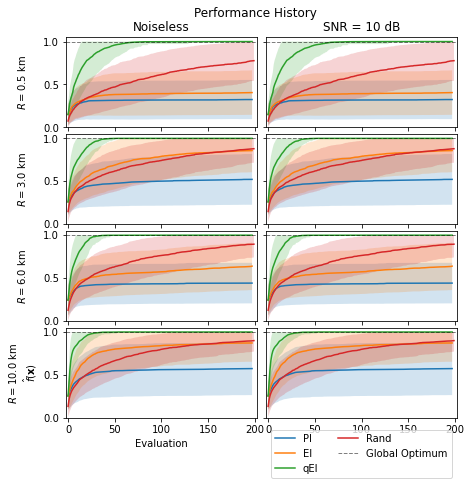

In [16]:
fig = plotting.plot_aggregated_data(
    dfr,
    evaluations,
    "best_value",
    optimum=1.0,
    upper_threshold=1.0,
    title="Performance History",
    xlabel="Evaluation",
    ylabel="$\hat{f}(\mathbf{x})$",
    xlim=[-2, 202],
    ylim=[0, 1.05]
)
# fig.savefig(FIGUREPATH / "RangeEst_PerfHist.png", dpi=200, facecolor="white", bbox_inches="tight")
plt.show()

Mean absolute error (MAE) for the 1000 Monte Carlo range estimation simulations is shown at each sequential evalution of the objective function.

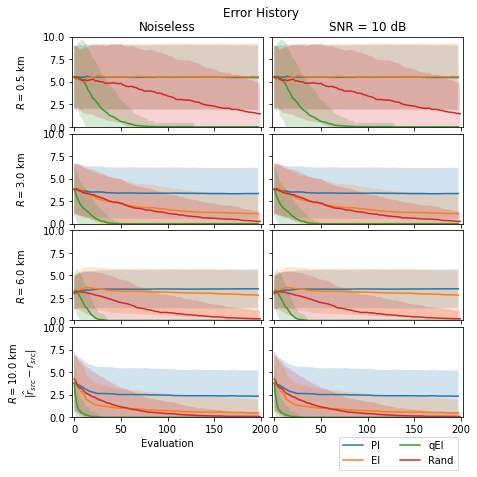

In [17]:
fig = plotting.plot_aggregated_data(
    dfr,
    evaluations,
    "best_param",
    compute_error_with=evaluations["rec_r"],
    title="Error History",
    xlabel="Evaluation",
    ylabel="$\\vert\hat{r}_{src} - r_{src}\\vert$",
    xlim=[-2, 202],
    ylim=[0, 10]
)
# fig.savefig(FIGUREPATH / "RangeEst_PerfHist.png", dpi=200, facecolor="white", bbox_inches="tight")
plt.show()

Drill down into one of the simulations to see how BOGP progresses.

In [3]:
DATA_FOLDER = EXPERIMENT1 / "acq_func=ExpectedImprovement__snr=Inf__rec_r=3.0" / "Runs" / "0063373286"
optim_config = torch.load(DATA_FOLDER / "optim.pth", map_location=torch.device("cpu"))
results = BOGPResults().load(DATA_FOLDER / "results.pth")

In [4]:
model_data = np.load(DATA_FOLDER.parent.parent / "measured" / "measured.npz")
K = model_data["covariance"]
p_rec = model_data["pressure"]
with open(DATA_FOLDER.parent.parent / "measured" / "parameters.pkl", "rb") as f:
    parameters = pickle.load(f)

In [5]:
optim_config["obj_func_kwargs"] = {
    "K": K,
    "parameters": parameters
}

In [6]:
search_parameters = [{"name": "x1", "bounds": [0.001, 10]}]
X_test = torch.linspace(
    search_parameters[0]["bounds"][0], search_parameters[0]["bounds"][1], 1001
).unsqueeze(1)

/Users/williamjenkins/Research/Projects/BOGP/Source/BOGP/optimization/plotting.py:165: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(6, 4), facecolor="white")


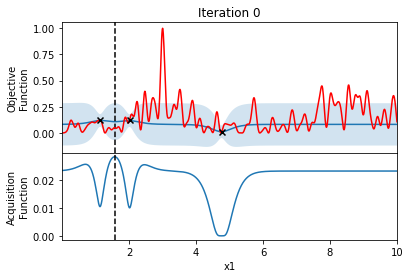

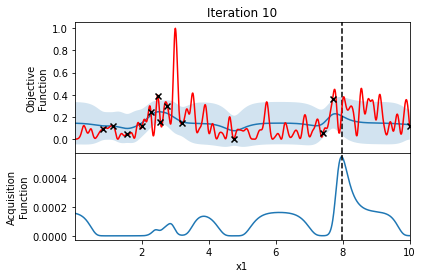

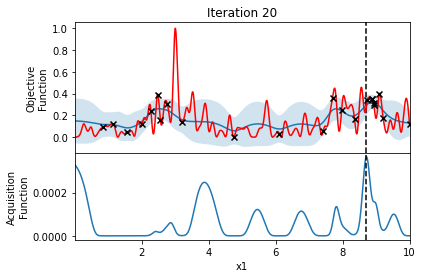

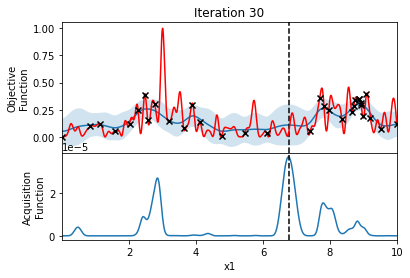

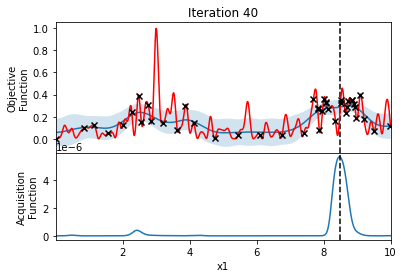

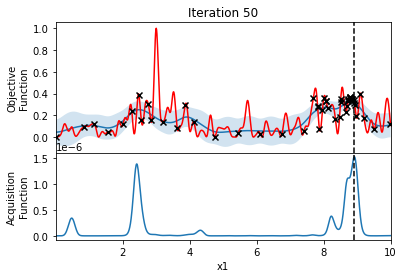

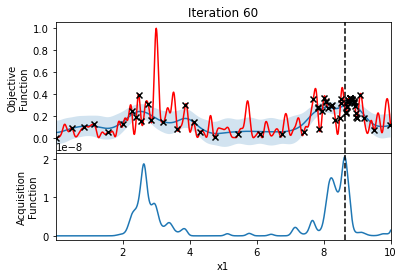

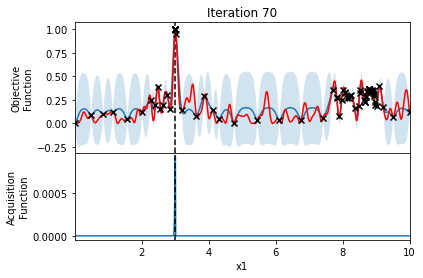

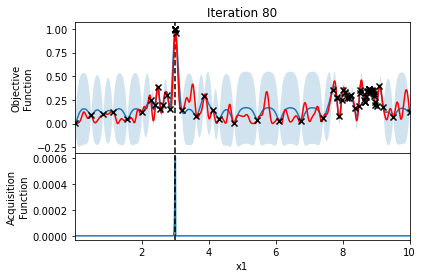

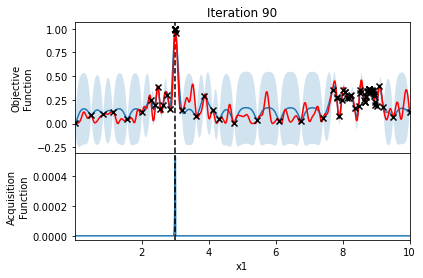

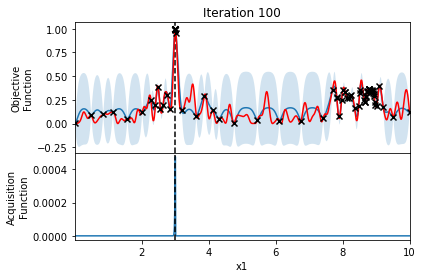

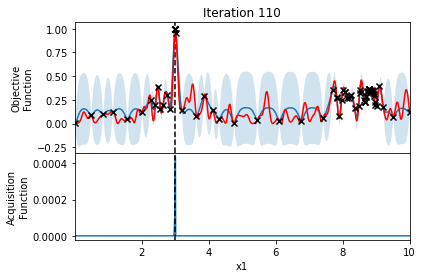

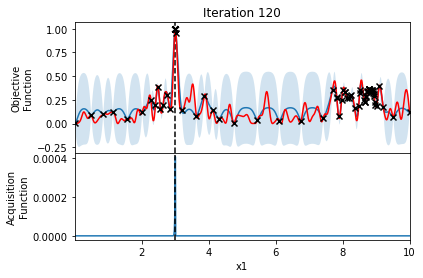

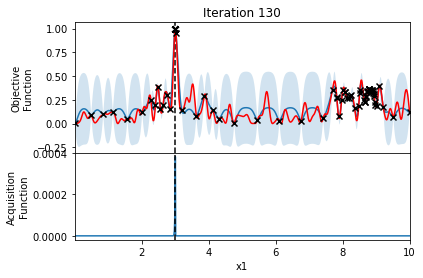

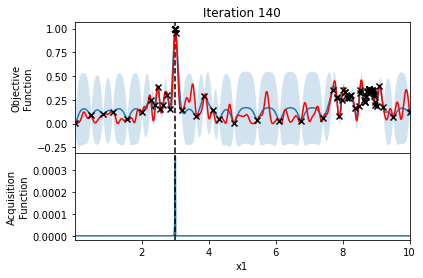

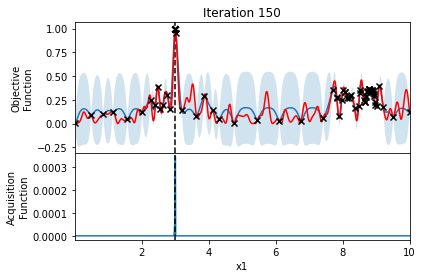

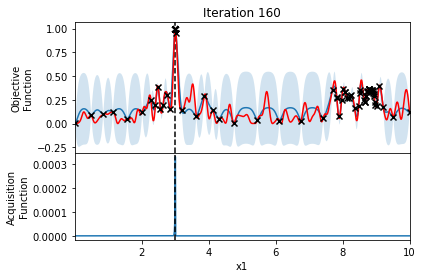

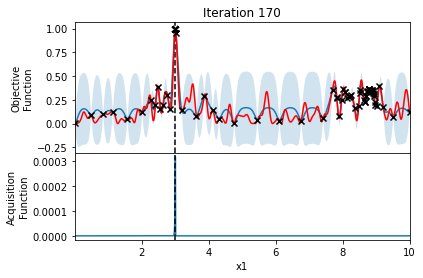

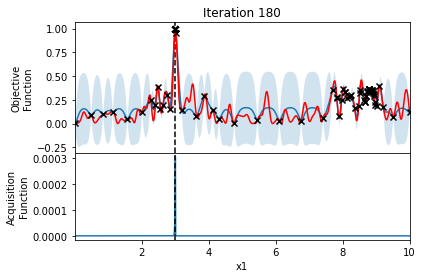

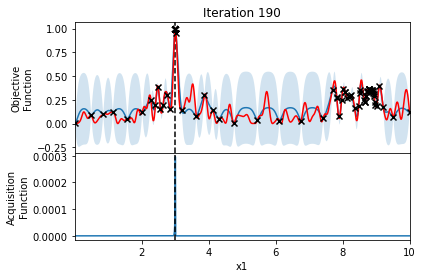

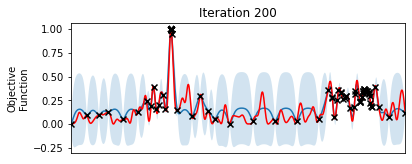

In [7]:
pltr = plotting.ResultsPlotter(optim_config, results)
parameters_to_plot = ["x1"]
pltr.plot_training_iterations(X_test, parameters_to_plot, index=np.linspace(0, 200, 21, dtype=int).tolist(), parameter_labels="Range [km]")

### Source Localization

In [2]:
evaluations = {
    "acq_func": ["ProbabilityOfImprovement", "ExpectedImprovement", "qExpectedImprovement", "random"],
    "acq_func_abbrev": ["PI", "EI", "qEI", "Rand"],
    "snr": ["inf", "10"],
    "rec_r": ["0.5", "3.0", "6.0", "10.0"],
    "src_z": ["62"]
}
# folders = utils.folders_of_evaluations(evaluations)

In [3]:
EXPERIMENT1 = DATAPATH / "bogp" / "localization"
df1 = pd.read_csv(EXPERIMENT1 / "aggregated.csv", index_col=0)
new_cols = df1["best_param"].str.strip("[ ").str.strip(" ]").str.split(" ", n=1, expand=True)
new_cols.columns = [f"best_param{col}" for col in new_cols.columns]
df1 = pd.concat([df1, new_cols], axis=1).drop("best_param", axis=1)
df1

acq_func   snr  rec_r       seed  evaluation  \
0       ProbabilityOfImprovement   inf    0.5    2406475           0   
1       ProbabilityOfImprovement   inf    0.5    2406475           1   
2       ProbabilityOfImprovement   inf    0.5    2406475           2   
3       ProbabilityOfImprovement   inf    0.5    2406475           3   
4       ProbabilityOfImprovement   inf    0.5    2406475           4   
...                          ...   ...    ...        ...         ...   
459454      qExpectedImprovement  10.0   10.0  998126081         821   
459455      qExpectedImprovement  10.0   10.0  998126081         822   
459456      qExpectedImprovement  10.0   10.0  998126081         823   
459457      qExpectedImprovement  10.0   10.0  998126081         824   
459458      qExpectedImprovement  10.0   10.0  998126081         825   

        best_value best_param0   best_param1  
0         0.231227  2.30824737  122.37317396  
1         0.231227  2.30824737  122.37317396  
2         0.231227  2.30824737  122.37317396  
3         0.231227  2.30824737  122.37317396  
4         0.231227  2.30824737  122.37317396  
...            ...         ...           ...  
459454    0.999927  9.99947166   61.93464279  
459455    0.999927  9.99947166   61.93464279  
459456    0.999927  9.99947166   61.93464279  
459457    0.999927  9.99947166   61.93464279  
459458    0.999927  9.99947166   61.93464279  

[11550526 rows x 8 columns]

In [4]:
EXPERIMENT2 = DATAPATH / "random" / "localization"
df2 = pd.read_csv(EXPERIMENT2 / "aggregated.csv", index_col=0)
new_cols = df2["best_param"].str.strip("[ ").str.strip(" ]").str.split(" ", n=1, expand=True)
new_cols.columns = [f"best_param{col}" for col in new_cols.columns]
df2 = pd.concat([df2, new_cols], axis=1).drop("best_param", axis=1)
df2

acq_func   snr  rec_r       seed  evaluation  best_value best_param0  \
0        random   inf    0.5    2406475           0    0.145870    7.443771   
1        random   inf    0.5    2406475           1    0.145870    7.443771   
2        random   inf    0.5    2406475           2    0.145870    7.443771   
3        random   inf    0.5    2406475           3    0.156106   5.2506237   
4        random   inf    0.5    2406475           4    0.156106   5.2506237   
...         ...   ...    ...        ...         ...         ...         ...   
499995   random  10.0   10.0  998126081         995    0.598510  10.0841675   
499996   random  10.0   10.0  998126081         996    0.598510  10.0841675   
499997   random  10.0   10.0  998126081         997    0.598510  10.0841675   
499998   random  10.0   10.0  998126081         998    0.598510  10.0841675   
499999   random  10.0   10.0  998126081         999    0.598510  10.0841675   

       best_param1  
0        17.880856  
1        17.880856  
2        17.880856  
3        118.36955  
4        118.36955  
...            ...  
499995    59.42926  
499996    59.42926  
499997    59.42926  
499998    59.42926  
499999    59.42926  

[4000000 rows x 8 columns]

In [5]:
df = pd.concat([df1, df2])
df

acq_func   snr  rec_r       seed  evaluation  \
0       ProbabilityOfImprovement   inf    0.5    2406475           0   
1       ProbabilityOfImprovement   inf    0.5    2406475           1   
2       ProbabilityOfImprovement   inf    0.5    2406475           2   
3       ProbabilityOfImprovement   inf    0.5    2406475           3   
4       ProbabilityOfImprovement   inf    0.5    2406475           4   
...                          ...   ...    ...        ...         ...   
499995                    random  10.0   10.0  998126081         995   
499996                    random  10.0   10.0  998126081         996   
499997                    random  10.0   10.0  998126081         997   
499998                    random  10.0   10.0  998126081         998   
499999                    random  10.0   10.0  998126081         999   

        best_value best_param0   best_param1  
0         0.231227  2.30824737  122.37317396  
1         0.231227  2.30824737  122.37317396  
2         0.231227  2.30824737  122.37317396  
3         0.231227  2.30824737  122.37317396  
4         0.231227  2.30824737  122.37317396  
...            ...         ...           ...  
499995    0.598510  10.0841675      59.42926  
499996    0.598510  10.0841675      59.42926  
499997    0.598510  10.0841675      59.42926  
499998    0.598510  10.0841675      59.42926  
499999    0.598510  10.0841675      59.42926  

[15550526 rows x 8 columns]

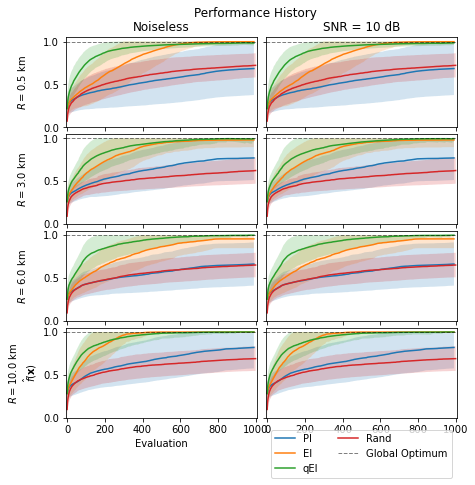

In [8]:
fig = plotting.plot_aggregated_data(
    df,
    evaluations,
    "best_value",
    optimum=1.0,
    upper_threshold=1.0,
    title="Performance History",
    xlabel="Evaluation",
    ylabel="$\hat{f}(\mathbf{x})$",
    xlim=[-5, 1005],
    ylim=[0, 1.05]
)
# fig.savefig(FIGUREPATH / "Localization_PerfHist.png", dpi=200, facecolor="white", bbox_inches="tight")
plt.show()

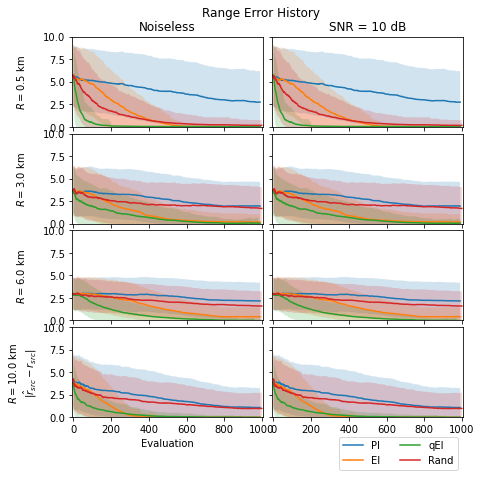

In [9]:
fig = plotting.plot_aggregated_data(
    df,
    evaluations,
    "best_param0",
    compute_error_with=evaluations["rec_r"],
    title="Range Error History",
    xlabel="Evaluation",
    ylabel="$\\vert\hat{r}_{src} - r_{src}\\vert$",
    xlim=[-5, 1005],
    ylim=[0, 10]
)
# fig.savefig(FIGUREPATH / "RangeEst_PerfHist.png", dpi=200, facecolor="white", bbox_inches="tight")
plt.show()

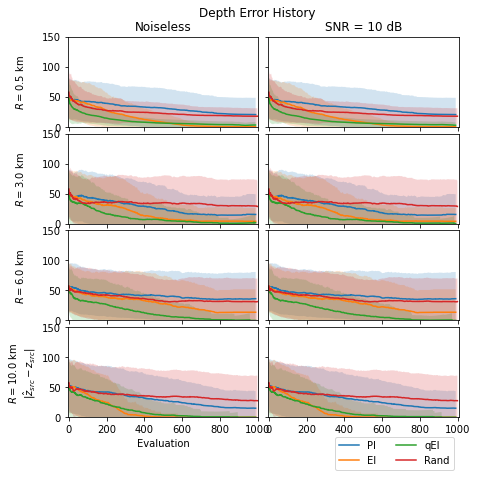

In [10]:
fig = plotting.plot_aggregated_data(
    df,
    evaluations,
    "best_param1",
    compute_error_with=float(evaluations["src_z"][0]),
    title="Depth Error History",
    xlabel="Evaluation",
    ylabel="$\\vert\hat{z}_{src} - z_{src}\\vert$",
    xlim=[-5, 1005],
    ylim=[0, 150]
)
plt.show()

In [7]:
DATA_FOLDER = EXPERIMENT / "acq_func=qExpectedImprovement__snr=inf__rec_r=3.0__src_z=62" / "Runs" / "0075533339" # This one converges on the correct parameters.
optim_config = torch.load(DATA_FOLDER / "optim.pth", map_location=torch.device("cpu"))
results = Results().load(DATA_FOLDER / "results.pth")

In [8]:
model_data = np.load(DATA_FOLDER.parent.parent / "measured" / "measured.npz")
K = model_data["covariance"]
p_rec = model_data["pressure"]
with open(DATA_FOLDER.parent.parent / "measured" / "parameters.pkl", "rb") as f:
    parameters = pickle.load(f)

In [9]:
optim_config["obj_func_kwargs"] = {
    "K": K,
    "parameters": parameters
}

In [10]:
search_parameters = [
    {"name": "rec_r", "bounds": [0.001, 10]},
    {"name": "src_z", "bounds": [0, 200]}
]

X_test = torch.cartesian_prod(
    torch.linspace(
        search_parameters[0]["bounds"][0], search_parameters[0]["bounds"][1], 101
    ),
    torch.linspace(
        search_parameters[1]["bounds"][0], search_parameters[1]["bounds"][1], 101
    )
).unsqueeze(1)

/home/wfjenkin/miniconda3/envs/gp/lib/python3.10/site-packages/gpytorch/lazy/lazy_tensor.py:1811: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


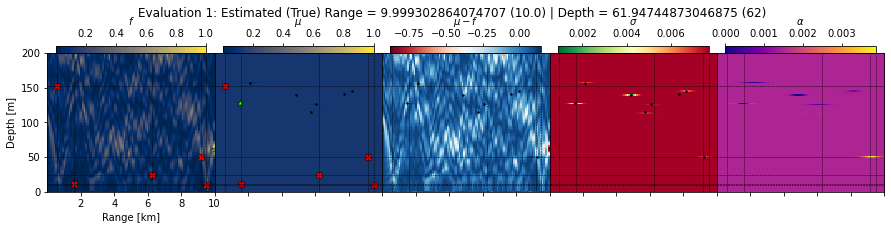

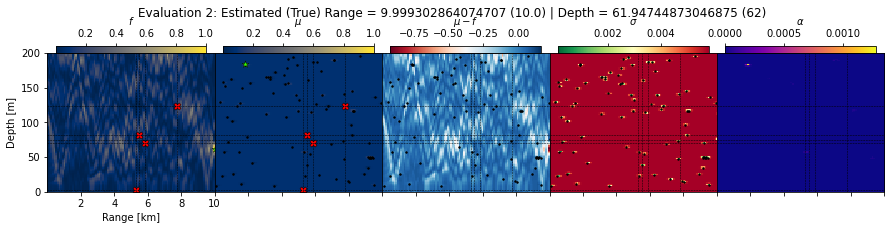

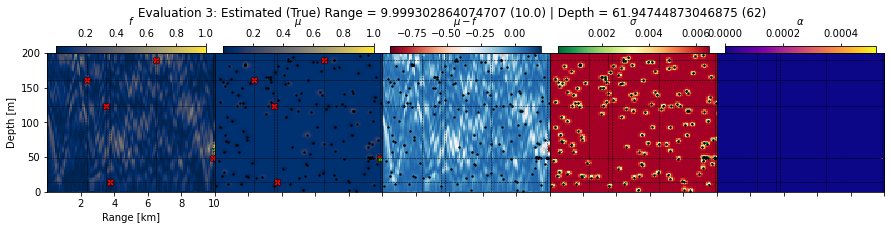

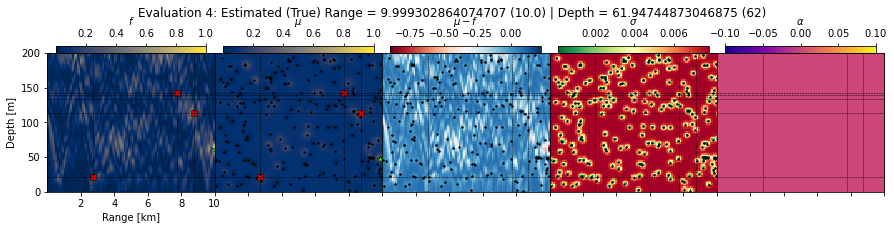

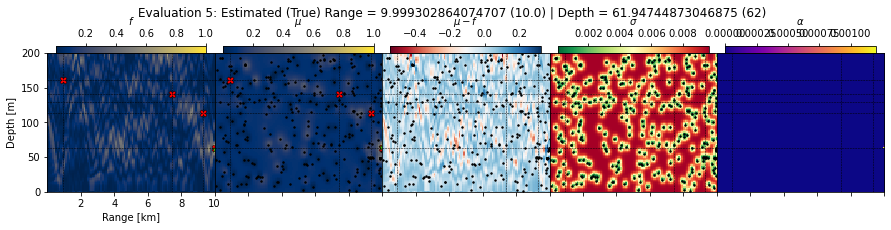

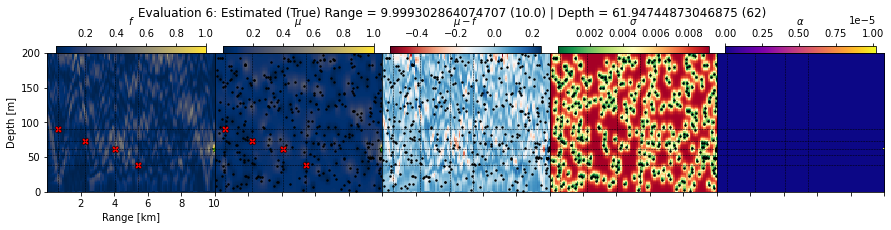

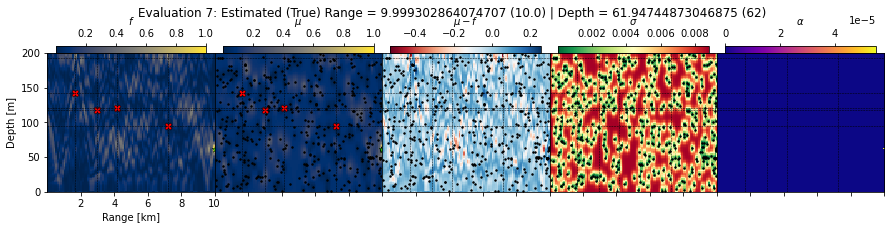

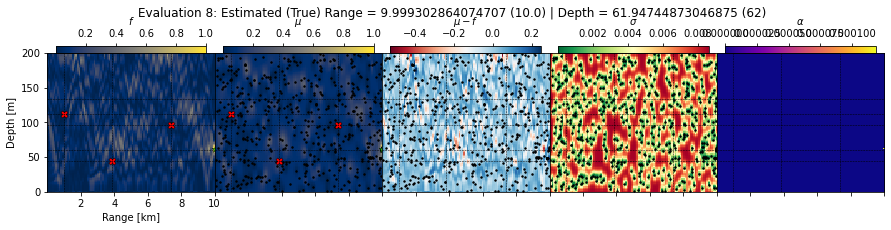

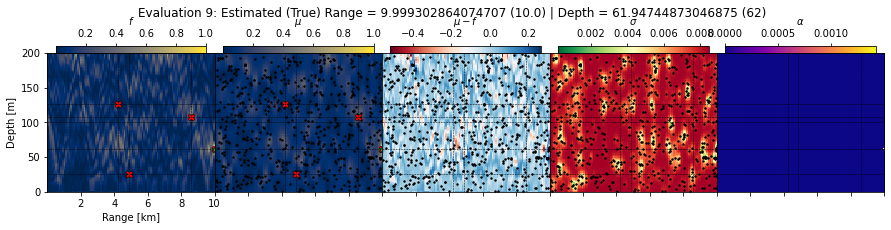

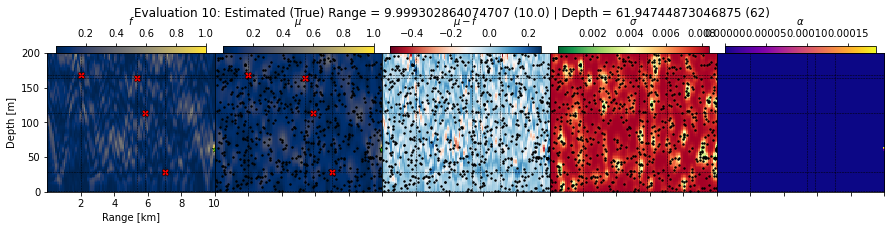

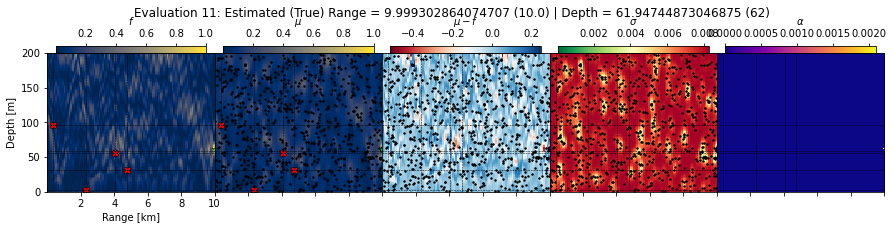

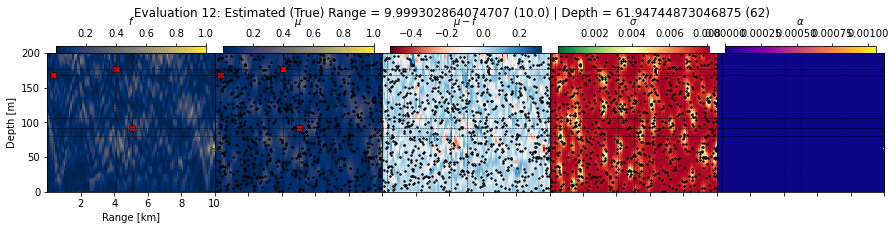

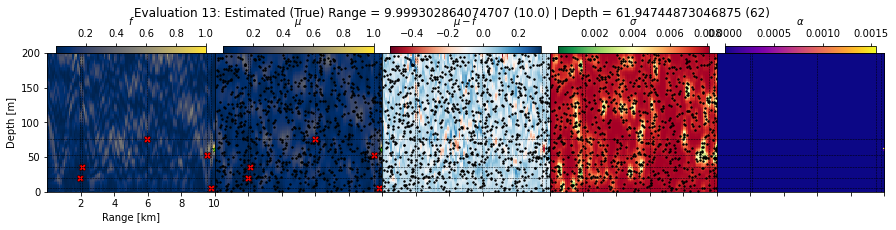

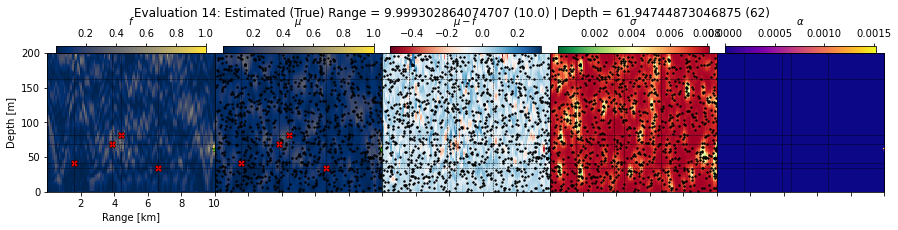

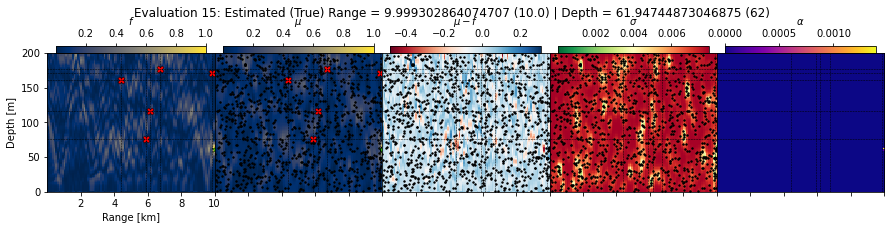

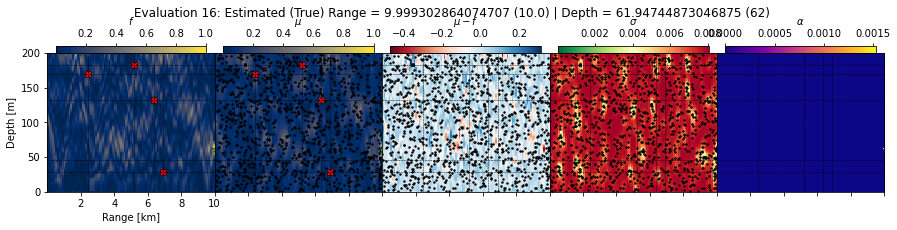

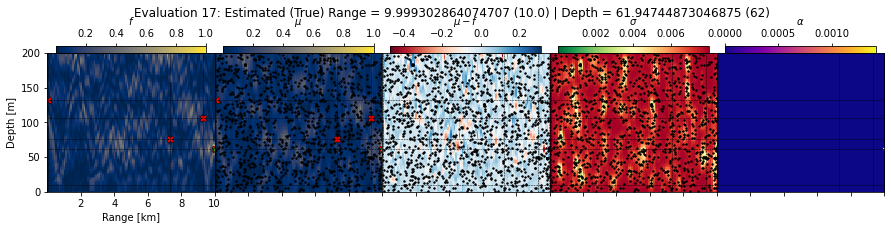

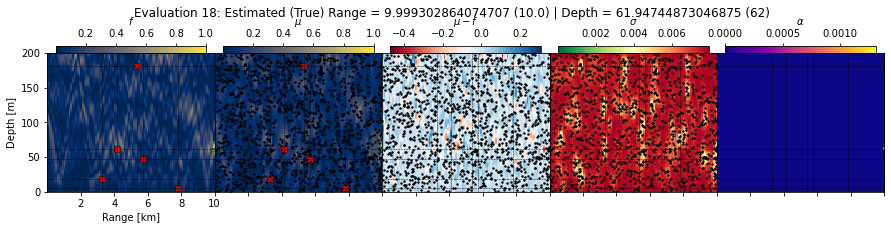

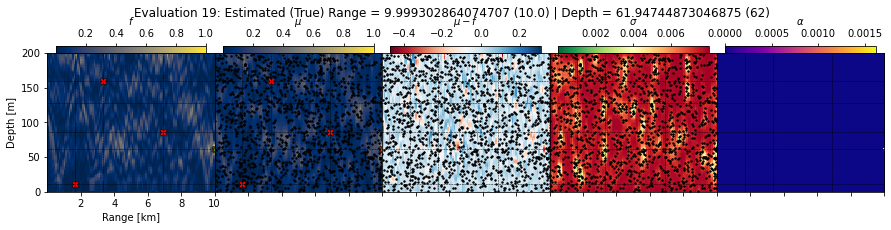

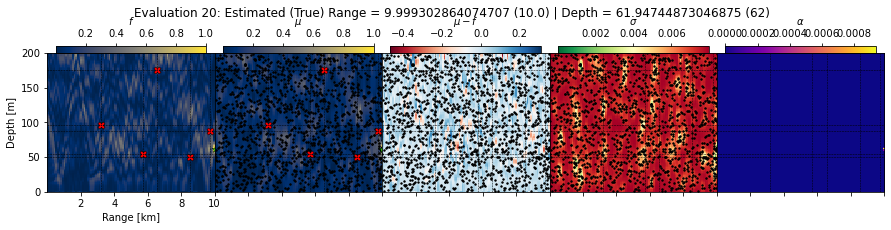

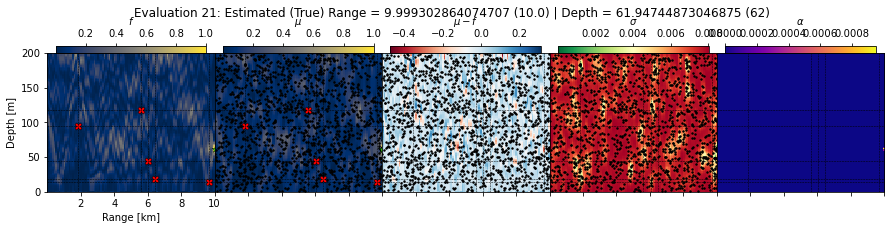

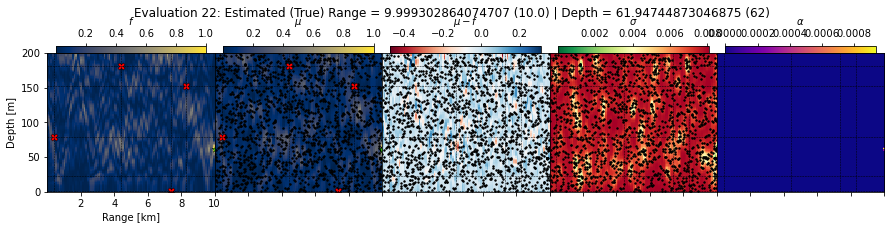

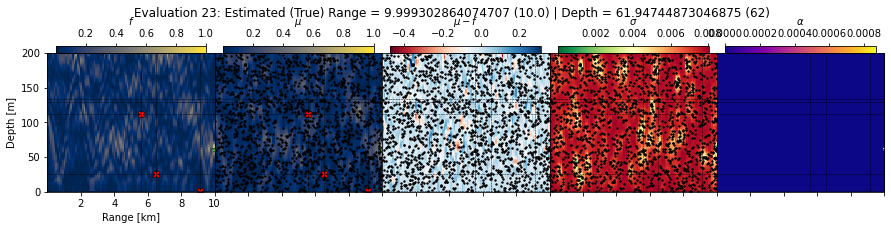

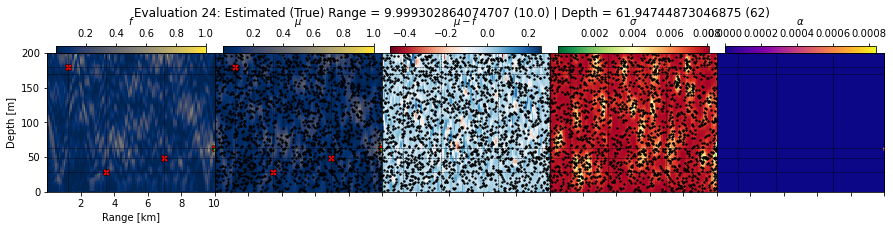

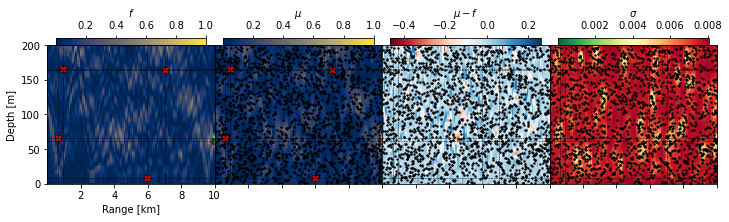

<AxesSubplot:>

In [11]:
pltr = plotting.ResultsPlotter(optim_config, results)
parameters_to_plot = ["rec_r", "src_z"]
pltr.plot_training_iterations(X_test, parameters_to_plot, parameter_labels=["Range [km]", "Depth [m]"], index=np.arange(0, 501, 20))